In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import uproot
import glob
import yaml

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"].array("limit")
    quant = f["limit"].array("quantileExpected")
    if limit.shape[0] == 1:
        return np.stack([-1])
    else:
        return np.stack([quant,limit])
    
def mass_points(dh="50"):
    mass_points = {}
    for p in glob.glob("./fitroom/*mhs{}*.root".format(dh)):
        mass_points[p] = [int(s) for s in re.findall(r'\d+',p)[:]]
    return mass_points

def get_cross_section(file):
    name = os.path.basename(file)
    with open("./config/xsection-DM.yaml", 'r') as stream:
        xsecs = yaml.safe_load(stream)
    name = name.replace("AsymptoticLimits.expected.noFitAsimov.","")
    name = name.replace(".root","")
    xsec = xsecs[name]
    return xsec.get("xsec") * xsec.get("br") * xsec.get("kr")

In [ ]:
limit_MY = []
limit_mx = []
limit_lm = []
xsec = []
    
mhs = 50
for fn, mp in mass_points(str(mhs)).items():
    limit = get_limits(fn)
        
    if limit.shape == (2, 5):
        xsec.append(get_cross_section(fn))
        limit = np.array(limit).astype(float)
        limit_lm.append(limit)
        limit_MY.append(mp[0])
        limit_mx.append(mp[2])
    else:
        print("-> ", fn)
    
xsec = np.array(xsec)
data = pd.DataFrame(
        {
            #"obs" : 0.02*np.array(limit_lm)[:,1,5]/xsec,
            "exp" : 0.02*np.array(limit_lm)[:,1,2]/xsec,
            "m1s" : 0.02*np.array(limit_lm)[:,1,1]/xsec,
            "p1s" : 0.02*np.array(limit_lm)[:,1,3]/xsec,
            "m2s" : 0.02*np.array(limit_lm)[:,1,0]/xsec,
            "p2s" : 0.02*np.array(limit_lm)[:,1,4]/xsec,
            "MY"  : np.array(limit_MY),
            "MX"  : np.array(limit_mx),
            "Mhs" : np.repeat(mhs, len(limit_MY))
        }
)
data = data.sort_values(by=['MX'])
data = data.sort_values(by=['MY'])

print(data)

In [ ]:
df = pd.DataFrame.from_dict(data) 
df.to_csv('darkhiggs.csv', index = False, header=True)
df.to_pickle('darkhiggs.pkl')

In [2]:
import os
import matplotlib.colors as mcolors
from limitlib import fill_dummy_values, interpolate_rbf, dump_contour_to_txt

pjoin = os.path.join

import mplhep as hep

plt.style.use(hep.style.CMS)

cmap = mcolors.LinearSegmentedColormap.from_list("n", list(reversed([
    # '#fff5f0',
    '#fee0d2',
    '#ffffff',
    '#fcbba1',
    '#fc9272',
    '#fb6a4a',
    '#ef3b2c',
    '#cb181d',
    '#a50f15',
    '#67000d',
    # '#000000',
        ])))

In [3]:
def plot2d(df):
    plt.clf()
    fig = plt.figure(figsize=(14,10))
    ax = plt.gca()
    plt.plot()

    #excluded = df['exp'] < 1

    x = df['MY']
    y = df['MX']
    exp = df['exp']
    p1s = df['p1s']
    m1s = df['m1s']
    p2s = df['p2s']
    m2s = df['m2s']
    
    #mask = ~((x==1600) & (y==650))
    #x = x[mask]
    #y = y[mask]
    #exp = exp[mask]
    #p1s = p1s[mask]
    #m1s = m1s[mask]
    #p2s = p2s[mask]
    #m2s = m2s[mask]

    contours_filled = np.log10(np.logspace(-1,1,7))
    contours_line = [0]
    
    def get_x_y_z(x,y,z):
        ix, iy, iz = interpolate_rbf(x,y,z,maxval=3000)
        iz [iy>ix] = 1e9 #* np.exp(-(iy/ix))
        if True:
            iz = np.log10(iz)
            iz[iz<min(contours_filled)] = min(contours_filled)
        return ix, iy, iz

    ix, iy, iz = get_x_y_z(x, y, exp)
    print(ix)
    print(iy)
    print(iz)
    CF = plt.contourf(ix, iy, iz, levels=contours_filled, cmap=cmap)
    cb = plt.colorbar()
    for c in CF.collections:
        c.set_edgecolor("face")
        
    args = dict(colors='black',zorder=2,levels=contours_line)
    cs_exp = plt.contour(
                       ix, iy, iz,
                       linestyles=[(0, (5,1))],
                       linewidths=3,
                       **args)
    cs_exp.collections[0].set_label('Median expected')
    
    cs_p1s=plt.contour(
                *get_x_y_z(x,y,p1s),
                linestyles=[(0, (3,3))],
                linewidths=2,
                **args)
    cs_p1s.collections[0].set_label(r'68% expected')
    cs_m1s = plt.contour(
                *get_x_y_z(x,y,m1s),
                linestyles=[(0, (3,3))],
                linewidths=2,
                **args)
    
    cs_p2s=plt.contour(
                *get_x_y_z(x,y,p2s),
                linestyles=[(0, (1,5))],
                linewidths=2,
                **args)
    cs_p2s.collections[0].set_label(r'95% expected')
    cs_m1s = plt.contour(
                *get_x_y_z(x,y,m2s),
                linestyles=[(0, (1,5))],
                linewidths=2,
                **args)
    cb.set_label("95% CL observed upper limit on $\log_{10}(\mu)$")
    plt.clim([1e-1,1e1])
    
    ax.set_xlabel("$m_{\Phi}$ (GeV)")
    ax.set_ylabel("$m_{DM}$ (GeV)")
    ax = plt.gca()
    ax.set_ylim(0,1600)

    plt.legend(loc='upper left')

    plt.text(2800,1000,'\n'.join([f'Dark Higgs mass = 50 GeV','Majorana DM',]), ha='right',va='top')

    plt.text(2800,1100,"CMS", fontweight='bold', ha='right',va='bottom',fontsize=30)
    labels = hep.cms.label_base._exp_label(exp="",data=True, year='2016-2018', lumi=137)
    #hep.cms.label(data=True, year='2016-2018', lumi=137, loc=1)
    #for ext in 'pdf','png':
    #    fig.savefig(pjoin(outdir, f"tchan_2d.{ext}"))
    
    #hep.cms.label(data=True, year='2016-2018', lumi=137, label="Preliminary")
    #for ext in 'pdf','png':
    #    fig.savefig(pjoin(outdir, f"tchan_2d_preliminary.{ext}"))

    plt.plot(x,y,'+b')
    for ix, iy, iz in zip(x,y,exp):
        plt.text(ix, iy, f"{iz:.7f}",color='b',fontsize=10)

    #for ext in 'pdf','png':
    #    fig.savefig(pjoin(outdir, f"tchan_2d_points.{ext}"))

[[   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]
 [   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]
 [   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]
 ...
 [   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]
 [   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]
 [   0.           30.3030303    60.60606061 ... 2939.39393939
  2969.6969697  3000.        ]]
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [  30.3030303    30.3030303    30.3030303  ...   30.3030303
    30.3030303    30.3030303 ]
 [  60.60606061   60.60606061   60.60606061 ...   60.60606061
    60.60606061   60.60606061]
 ...
 [2939.39393939 2939.39393939 2939.39393939 ... 2939.39393939
  2939.39393939 2939.39393939]
 [2969.6969697  2969.6969697  2969.6969697  ... 2969.6969697
  2969.

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


<Figure size 720x720 with 0 Axes>

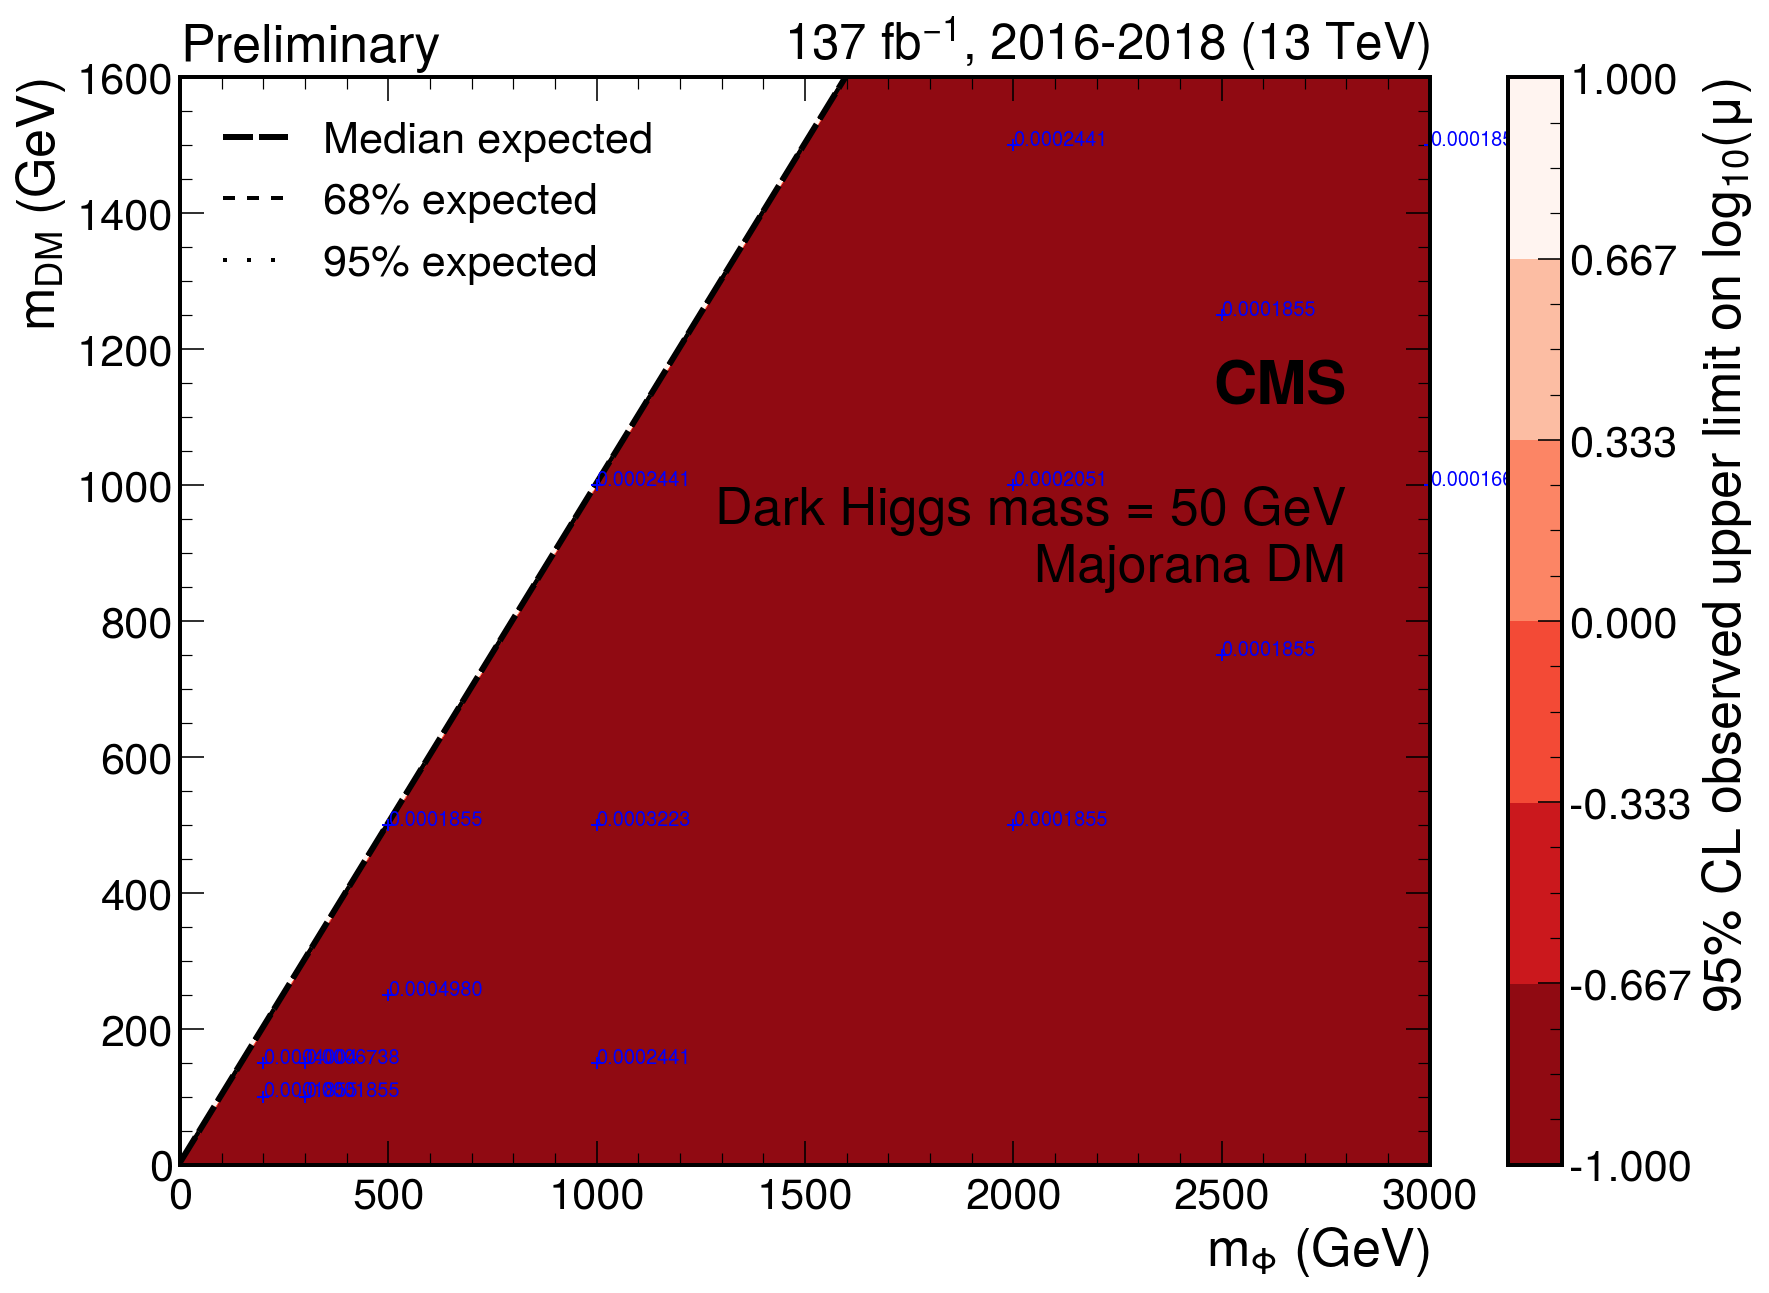

In [4]:
df = pd.read_pickle("darkhiggs.pkl")
plot2d(df)